In [5]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset (replace 'path/to/dataset' with the actual path)
dataset_path = 'Dataset/Images'

# Create an ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create a generator for loading and preprocessing the training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),    # Resize images to 64x64 pixels (adjust as needed)
    batch_size=batch_size,
    class_mode='categorical',  # Assumes you have categorical labels
    shuffle=True              # Shuffle the data during training
)


Found 357 images belonging to 14 classes.


In [7]:
from sklearn.model_selection import train_test_split
import os
from shutil import copyfile

# Define the path to your original dataset
original_dataset_path = 'Dataset/Images'

# Define the path to create your new split dataset
split_dataset_path = 'split'

# Define the ratio of data to be used for validation
validation_split = 0.2

# Create directories for the training and validation sets
train_dir = os.path.join(split_dataset_path, 'train')
val_dir = os.path.join(split_dataset_path, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Iterate through each class in the original dataset
for class_name in os.listdir(original_dataset_path):
    class_path = os.path.join(original_dataset_path, class_name)

    # Create directories for the current class in both training and validation sets
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # Get a list of all image filenames in the current class
    image_files = os.listdir(class_path)

    # Split the image filenames into training and validation sets
    train_files, val_files = train_test_split(image_files, test_size=validation_split, random_state=42)

    # Copy the training set images to the corresponding directory
    for filename in train_files:
        src = os.path.join(class_path, filename)
        dst = os.path.join(train_class_dir, filename)
        copyfile(src, dst)

    # Copy the validation set images to the corresponding directory
    for filename in val_files:
        src = os.path.join(class_path, filename)
        dst = os.path.join(val_class_dir, filename)
        copyfile(src, dst)

print("Dataset split into training and validation sets.")


Dataset split into training and validation sets.


In [11]:
from sklearn.preprocessing import LabelEncoder

# Function to load and convert images to arrays
def load_images_as_arrays(dataset_path):
    image_arrays = []
    labels = []

    label_encoder = LabelEncoder()  # Create a label encoder

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)

            # Check if the file is a valid image file
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                continue

            try:
                # Load image using Pillow (PIL)
                img = Image.open(image_path)
                img = img.resize((64, 64))  # Resize images to match the expected input size of your model

                # Convert image to NumPy array and normalize pixel values to be between 0 and 1
                img_array = np.array(img) / 255.0

                # Append the image array and corresponding label to the lists
                image_arrays.append(img_array)
                labels.append(class_name)
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")

    # Use label encoder to convert class names to integers
    encoded_labels = label_encoder.fit_transform(labels)

    return np.array(image_arrays), np.array(encoded_labels)

# Load training images and labels
X_train, y_train = load_images_as_arrays(train_dataset_path)

# Load validation images and labels
X_val, y_val = load_images_as_arrays(val_dataset_path)

# One-hot encode the labels
num_classes = len(set(y_train))  # Number of unique classes
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

# Print the shape of the loaded arrays
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train_one_hot.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val_one_hot.shape)


Shape of X_train: (273, 64, 64, 3)
Shape of y_train: (273, 14)
Shape of X_val: (84, 64, 64, 3)
Shape of y_val: (84, 14)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Assuming you have already defined X_train, y_train_one_hot, X_val, y_val_one_hot

# Create the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Use num_classes from your dataset

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a learning rate schedule function
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 50:
        lr *= 0.1  # Reduce learning rate by 10x after 50 epochs
    return lr

# Use LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with the learning rate scheduler callback
epochs = 100
batch_size = 32

history = model.fit(
    X_train, y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[lr_scheduler]
)


Epoch 1/100
9/9 [==============================] - 2s 99ms/step - loss: 2.7243 - accuracy: 0.0513 - val_loss: 2.5960 - val_accuracy: 0.1786 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 1s 65ms/step - loss: 2.5325 - accuracy: 0.1245 - val_loss: 2.4187 - val_accuracy: 0.1786 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 1s 67ms/step - loss: 2.2364 - accuracy: 0.2344 - val_loss: 2.0904 - val_accuracy: 0.2976 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 1s 65ms/step - loss: 1.8073 - accuracy: 0.4249 - val_loss: 1.7431 - val_accuracy: 0.4524 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 1s 65ms/step - loss: 1.4370 - accuracy: 0.5824 - val_loss: 1.5128 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 1s 70ms/step - loss: 1.0484 - accuracy: 0.7143 - val_loss: 1.2172 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 1s 64ms/step - loss: 0.7977 - a

3/3 [==============================] - 0s 18ms/step


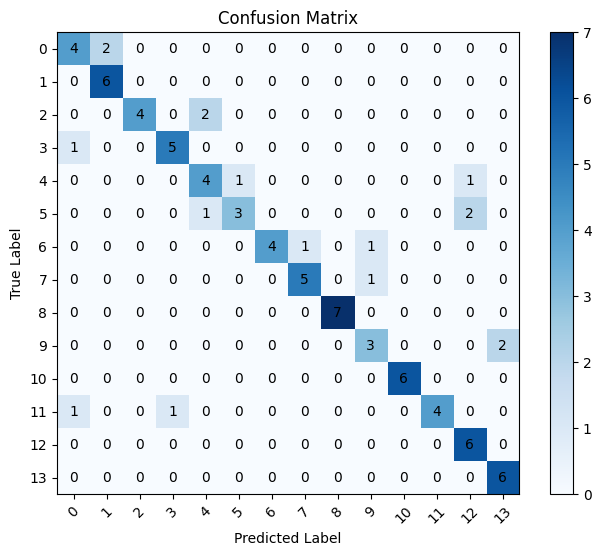

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.75      1.00      0.86         6
           2       1.00      0.67      0.80         6
           3       0.83      0.83      0.83         6
           4       0.57      0.67      0.62         6
           5       0.75      0.50      0.60         6
           6       1.00      0.67      0.80         6
           7       0.83      0.83      0.83         6
           8       1.00      1.00      1.00         7
           9       0.60      0.60      0.60         5
          10       1.00      1.00      1.00         6
          11       1.00      0.67      0.80         6
          12       0.67      1.00      0.80         6
          13       0.75      1.00      0.86         6

    accuracy                           0.80        84
   macro avg       0.82      0.79      0.79        84
weighted avg       0.82      0.80      0.79        84



In [19]:
# Assuming you have predictions from the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_one_hot, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = range(num_classes)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the values inside the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')

plt.show()

# Display the classification report
report = classification_report(y_true_classes, y_pred_classes)
print(report)

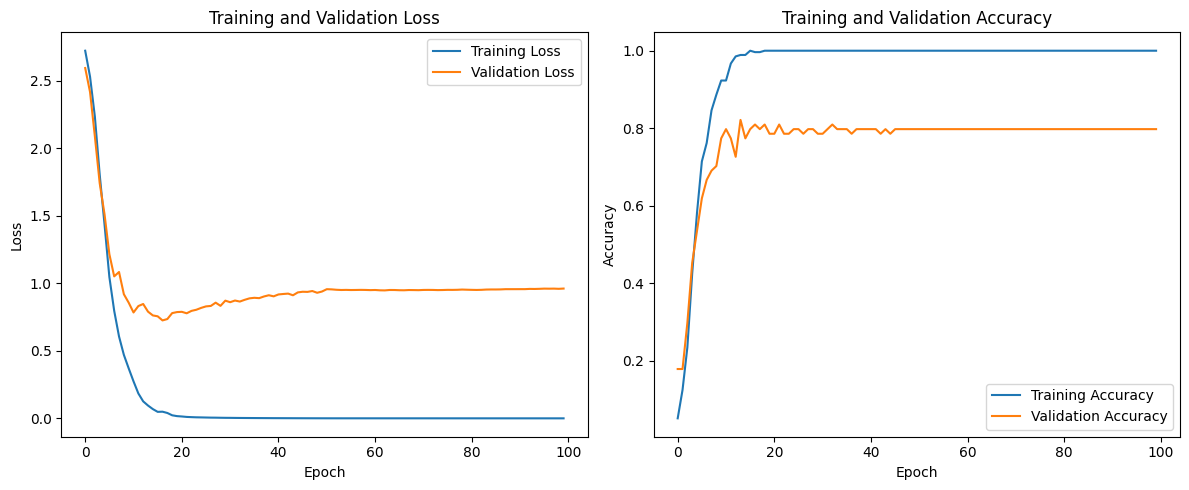

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
model.save("Models/model.h5")

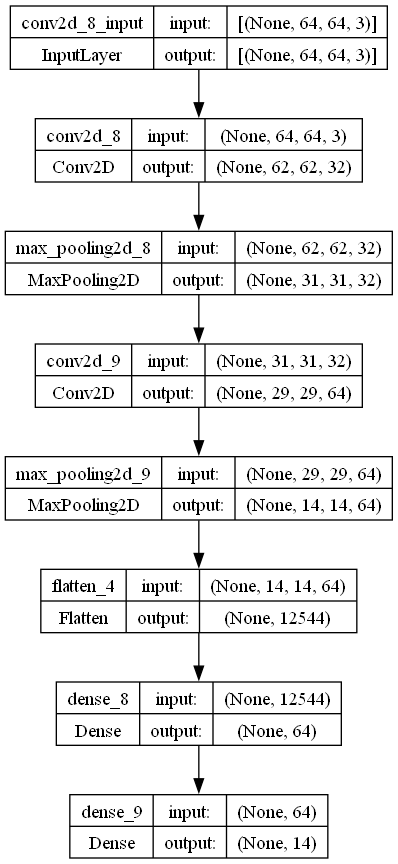

In [22]:
from keras.utils import plot_model
import tensorflow as tf
mod = tf.keras.saving.load_model("Models/model.h5")
plot_model(mod, to_file='Images/model_architecture.png', show_shapes=True, show_layer_names=True)

1/1 [==============================] - 0s 85ms/step


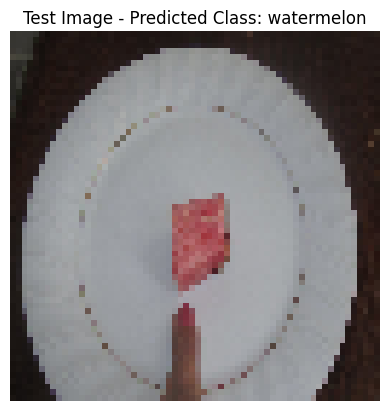

In [41]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
saved_model_path = 'Models/model.h5'  # Replace with the actual path to your saved model
loaded_model = load_model(saved_model_path)

# Load and preprocess the test image
test_image_path = 'split/validation/watermelon/14_17.jpg'  # Replace with the actual path to your test image
img = image.load_img(test_image_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size
img_array /= 255.0  # Normalize pixel values to be between 0 and 1

# Make predictions using the loaded model
predictions = loaded_model.predict(img_array)

# Convert predictions to class labels
predicted_class_index = np.argmax(predictions)
class_labels = {0: 'Apple', 1: 'Bannana', 2: 'beans', 3: 'carrot', 4:'Cheese',5:'cucumber',6:'Onion',7:'Orange',8:'Pasta',9:'Pepper',10:'Qiwi',11:'sauce',12:'tomato',13:'watermelon'}  # Define your class labels
predicted_class_label = class_labels[predicted_class_index]

# Display the input image
plt.imshow(img)
plt.title(f'Test Image - Predicted Class: {predicted_class_label}')
plt.axis('off')  # Hide axis
plt.show()

if predicted_class_index == 0:
    print("Number of calories : 52")
elif predicted_class_index == 1:
    print("Number of calories : 89")
elif predicted_class_index == 2:
    print("Number of calories : 347")
elif predicted_class_index == 3:
    print("Number of calories : 41")
elif predicted_class_index == 4:
    print("Number of calories : 402")
elif predicted_class_index == 5:
    print("Number of calories : 15")
elif predicted_class_index == 6:
    print("Number of calories : 40")
elif predicted_class_index == 7:
    print("Number of calories : 47")
elif predicted_class_index == 8:
    print("Number of calories : 131")
elif predicted_class_index == 9:
    print("Number of calories : 20")
elif predicted_class_index == 10:
    print("Number of calories : 61")
elif predicted_class_index == 11:
    print("Number of calories : 29")
elif predicted_class_index == 12:
    print("Number of calories : 19")
elif predicted_class_index == 13:
    print("Number of calories : 30")
else:
    print("couldnt find the calories")


